<a href="https://colab.research.google.com/github/MusanjeRichard5/ML_DL_UseCases/blob/main/Cocoa_Detection_Harvest___Haven_notebook_edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HARVEST HAVEN TEAM NOTEBOOK FOR COCOA DATASET HACKATHON ORGANISED BY MAKERERE AI LAB

Firstly we extend our appreciations to organising team of Makerere AI lab for organising this Hackathon. It was an opportunity for us to learn and improve our skills

TASK
Use the provided cocoa dataset to develop an object detection model

APPROACH


1. We first  the bench marked with a starter notebook that was provided by organisers, we achieved a score of 0.65
2. We performed augmentation on the train dataset using basic approaches of vertical flip , rotation , brightness, RGB shift , with this our perfomance improved to 0.7
3. We then applied mosaic augmentation, combined with one above and achieved 0.73





In [ ]:
# Install requirements
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.4/778.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 54.9 MB/s eta 0:00:00


In [ ]:
# Import libraries
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import glob
from PIL import Image
import pandas as pd
import os
import random
import yaml
import numpy as np
import matplotlib.patches as patches
import albumentations as A
import cv2
import shutil

This notebook will show how to train a YOLO8 model for object detection. We shall show how to:
1. Create YOLO format labels from the provided [CSV](https://github.com/AI-Lab-Makerere/CV4Agriculture_Hackathon24/blob/main/resources/cocoa_sample/label_map.csv)
2. Create train, validation and test datasets.
3. Train, Evaluate and Test a Baseline Model
4. Create  a submission file.
5. (Optional) - export a mobile optimized model

## Basic exploration

In [ ]:
# Get the data
! wget https://storage.googleapis.com/air-lab-hackathon/Cocoa/cocoa_new.zip
! unzip cocoa_new.zip

Streaming output truncated to the last 5000 lines.
  inflating: cocoa_new/valid/img_2510_JPG_jpg.rf.1b26ec4ea50a73ed84473a25058fe168.jpg  
  inflating: cocoa_new/valid/img_2954_JPG_jpg.rf.d86e11a6386434ec4c5e9bdbd0c66ecf.xml  
  inflating: cocoa_new/valid/img_3920_JPG_jpg.rf.7197873115df59abc4f4130485aba87a.jpg  
  inflating: cocoa_new/valid/img_2510_JPG_jpg.rf.1b26ec4ea50a73ed84473a25058fe168.xml  
  inflating: cocoa_new/valid/img_3082_JPG_jpg.rf.22386dfd0e7220f0261af55f754ac632.jpg  
  inflating: cocoa_new/valid/img_2988_JPG_jpg.rf.d5bd9411b7eba4016505af66b56b82f4.jpg  
  inflating: cocoa_new/valid/img_255_JPG_jpg.rf.3443a4428310daa987a86fdab5ca5e9a.xml  
  inflating: cocoa_new/valid/img_4084_JPG_jpg.rf.159bae477531188c72b3d3a96f66645c.jpg  
  inflating: cocoa_new/valid/img_885_JPG_jpg.rf.5cd9269fad3cbbc6fa995e0ee41b20a1.xml  
  inflating: cocoa_new/valid/img_885_JPG_jpg.rf.5cd9269fad3cbbc6fa995e0ee41b20a1.jpg  
  inflating: cocoa_new/valid/img_2988_JPG_jpg.rf.d5bd9411b7eba4016505af6

In [ ]:
import pathlib
data_dir = 'cocoa_new/train/'
data_dir = pathlib.Path(data_dir).with_suffix('')

image_count = len(list(data_dir.glob('*.jpg')))
print(f'Found {image_count} images')

Found 2274 images


Lets look at some of the images

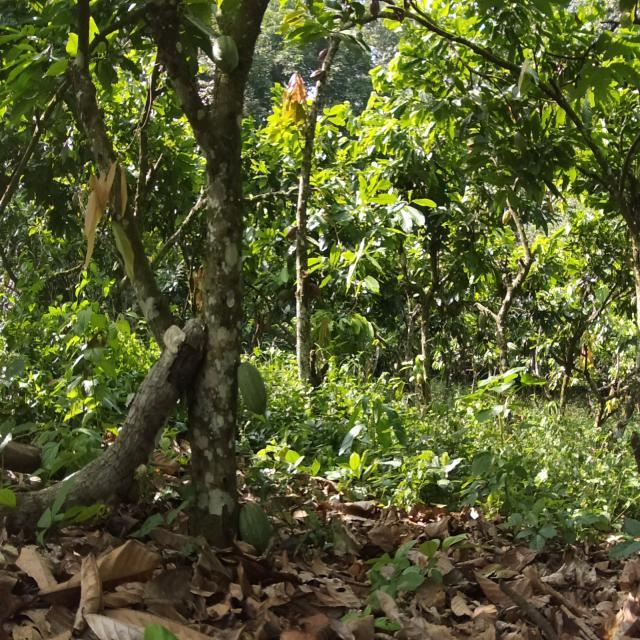

In [ ]:
image_list = list(data_dir.glob('*.jpg'))
Image.open(str(image_list[0]))

Lets visualize some of the data with the annotations. Ton do this, we shall load the bounding box coordinates from the label_map csv file and then draw them on the image.
lets define some helper functions.

In [ ]:
# Load csv file
label_data = pd.read_csv('cocoa_new/train/label_map.csv')
label_data.head()

Image id Actual Label  xmin  ymin  \
0  img_3256_JPG_jpg.rf.1899430ea344d59c764337efc8...        Spoit   351   240   
1  img_3256_JPG_jpg.rf.1899430ea344d59c764337efc8...        Spoit   295   370   
2  img_3256_JPG_jpg.rf.1899430ea344d59c764337efc8...        Spoit   517   436   
3  img_3256_JPG_jpg.rf.1899430ea344d59c764337efc8...        Spoit   271   333   
4  img_3256_JPG_jpg.rf.1899430ea344d59c764337efc8...        Spoit   291   184   

   xmax  ymax  xmin_norm  xmax_norm  ymin_norm  ymax_norm  
0   380   285   0.548438   0.593750   0.375000   0.593750  
1   337   408   0.460938   0.526563   0.578125   0.526563  
2   535   465   0.807813   0.835938   0.681250   0.835938  
3   297   375   0.423438   0.464062   0.520312   0.464062  
4   319   220   0.454688   0.498437   0.287500   0.498437

In [ ]:
# May need to check data types incase conversions need to be made
label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12265 entries, 0 to 12264
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Image id      12265 non-null  object 
 1   Actual Label  12265 non-null  object 
 2   xmin          12265 non-null  int64  
 3   ymin          12265 non-null  int64  
 4   xmax          12265 non-null  int64  
 5   ymax          12265 non-null  int64  
 6   xmin_norm     12265 non-null  float64
 7   xmax_norm     12265 non-null  float64
 8   ymin_norm     12265 non-null  float64
 9   ymax_norm     12265 non-null  float64
dtypes: float64(4), int64(4), object(2)
memory usage: 958.3+ KB


In [ ]:
label_data.columns

Index(['Image id', 'Actual Label', 'xmin', 'ymin', 'xmax', 'ymax', 'xmin_norm',
       'xmax_norm', 'ymin_norm', 'ymax_norm'],
      dtype='object')

In [ ]:
#reading the validation data
val_data = pd.read_csv("/content/cocoa_new/valid/label_map.csv")

In [ ]:
val_data.head()

Image id   Actual Label  xmin  \
0  img_918_JPG_jpg.rf.2925fc0af80490726e9f2e63962...  Mature_Unripe   365   
1  img_918_JPG_jpg.rf.2925fc0af80490726e9f2e63962...  Mature_Unripe   362   
2  img_3109_JPG_jpg.rf.6856b88977920c2de2a1529d9c...  Mature_Unripe   139   
3  img_3109_JPG_jpg.rf.6856b88977920c2de2a1529d9c...  Mature_Unripe   171   
4  img_3109_JPG_jpg.rf.6856b88977920c2de2a1529d9c...  Mature_Unripe   208   

   ymin  xmax  ymax  xmin_norm  xmax_norm  ymin_norm  ymax_norm  
0   180   409   263   0.570312   0.639062   0.281250   0.639062  
1   341   430   417   0.565625   0.671875   0.532813   0.671875  
2   387   166   430   0.217188   0.259375   0.604688   0.259375  
3   370   197   407   0.267188   0.307812   0.578125   0.307812  
4   354   230   388   0.325000   0.359375   0.553125   0.359375

In [ ]:
def extract_bounding_boxes(df, img_id):
  return df[df['Image id']==img_id][['xmin', 'ymin', 'xmax', 'ymax', 'Actual Label']].values

In [ ]:
def extract_bounding_boxes_norm(data_f, img_name):
  return data_f[data_f['Image id']==img_name][['xmin_norm', 'ymin_norm', 'xmax_norm', 'ymax_norm', 'Actual Label']].values

In [ ]:
def plot_image_with_bbox(img_path, bboxes):
    # Laod image
    img_arr = Image.open(img_path)

    fig, ax = plt.subplots(1)

    ax.imshow(img_arr)

    for bbox in bboxes:
        x, y, x1, y1, img_lbl = bbox
        # print(img_lbl)
        w = x1-x
        h = y1-y
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.text(x, y,img_lbl, color='b')
        ax.add_patch(rect)

    plt.axis('off')  # Turn off axis
    plt.show()

In [ ]:
def generate_yolo_label_4_Aug(df, img_id,img_width,img_height):
  bboxes = []
  #print(img_id)
  ext_boxes = extract_bounding_boxes(df, img_id)
  #img_width, img_height = (640,640)
  #print(ext_boxes)
  for b in ext_boxes:
      x1, y1, x2, y2, img_label =  b
      xc = ((x1 + x2)/2-1)/img_width
      #print(xc)
      yc  = ((y1 + y2)/2-1)/img_height
      #print(yc)
      width = ((x2 - x1))/img_width
      #print(width)
      height = ((y2 - y1))/img_height
      #print(height)

      #bboxes.append([x1, y1, x2, y2, img_label])
      if 0 <= xc <= 1 and 0 <= yc <= 1 and 0 <= width <= 1 and 0 <= height <= 1:
        bboxes.append([xc, yc, width, height, img_label])
      else:
            #If any value is out of range, return an empty list to indicate invalid bounding boxes
           return []
  return bboxes

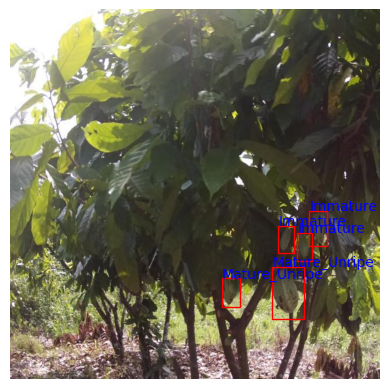

In [ ]:
# Select a random sample
sample_image = random.choice(image_list)
sample_bboxes = extract_bounding_boxes(label_data, os.path.basename(sample_image))
plot_image_with_bbox(sample_image, sample_bboxes)

Declaring transformation types

In [ ]:
bbox_params = {'format': 'yolo'}
#bbox_params = bboxes

albumentation_list = [A.Compose([A.RandomFog(p=1)], bbox_params=bbox_params),
                      A.Compose([A.RandomBrightness(p=1)], bbox_params=bbox_params),
                      A.Compose([A.RandomCrop(p=1, height=512, width=512)], bbox_params=bbox_params),
                      A.Compose([A.Rotate(p=1, limit=90)], bbox_params=bbox_params),
                      A.Compose([A.RGBShift(p=1)], bbox_params=bbox_params),
                      A.Compose([A.RandomSnow(p=1)], bbox_params=bbox_params),
                      A.Compose([A.VerticalFlip(p=1)], bbox_params=bbox_params),
                      A.Compose([A.RandomContrast(limit=0.5, p = 1)], bbox_params=bbox_params)
                     ]
titles_list = ["Original",
               "RandomFog",
               "RandomBrightness",
               "RandomCrop",
               "Rotate",
               "RGBShift",
               "RandomSnow",
               "VerticalFlip",
               "RandomContrast"]


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Visualizing transformations

In [ ]:

def draw_rect(img, bboxes, color=(255, 0, 0)):
    img = img.copy()
    for bbox in bboxes:
        # Check if bbox contains non-numeric values and skip it
        if isinstance(bbox, list) and all(isinstance(i, (int, float,str)) for i in bbox):
            bbox = np.array(bbox).astype(int)
            pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
            img = cv2.rectangle(img, pt1, pt2, color, int(max(img.shape[:2]) / 200))
    return img


def plot_multiple_img(img_matrix_list, title_list, ncols, nrows=3, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=nrows, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):

        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
        myaxes[i // ncols][i % ncols].grid(False)
        myaxes[i // ncols][i % ncols].set_xticks([])
        myaxes[i // ncols][i % ncols].set_yticks([])

    plt.show()
def visualize_transformed_images(image_path):
  image = cv2.imread(str(image_path))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  img_width = image.shape[1]
  img_height = image.shape[0]
  bboxes = generate_yolo_label_4_Aug(label_data, os.path.basename(image_path), img_width,img_height)

  #adding the orginal image to the image matrix
  sample_bboxes=extract_bounding_boxes(label_data, os.path.basename(image_path))
  img_matrix_list = [draw_rect(image, sample_bboxes)]

  #ploting the augmented images
  for aug_type in albumentation_list:
    anno = aug_type(image=image, bboxes=bboxes, labels=np.ones(len(bboxes)))
    img  = draw_rect(anno['image'], anno['bboxes'])
    img_matrix_list.append(img)

  plot_multiple_img(img_matrix_list,
                  titles_list,
                  ncols = 3,
                  main_title="Different Types of Augmentations")

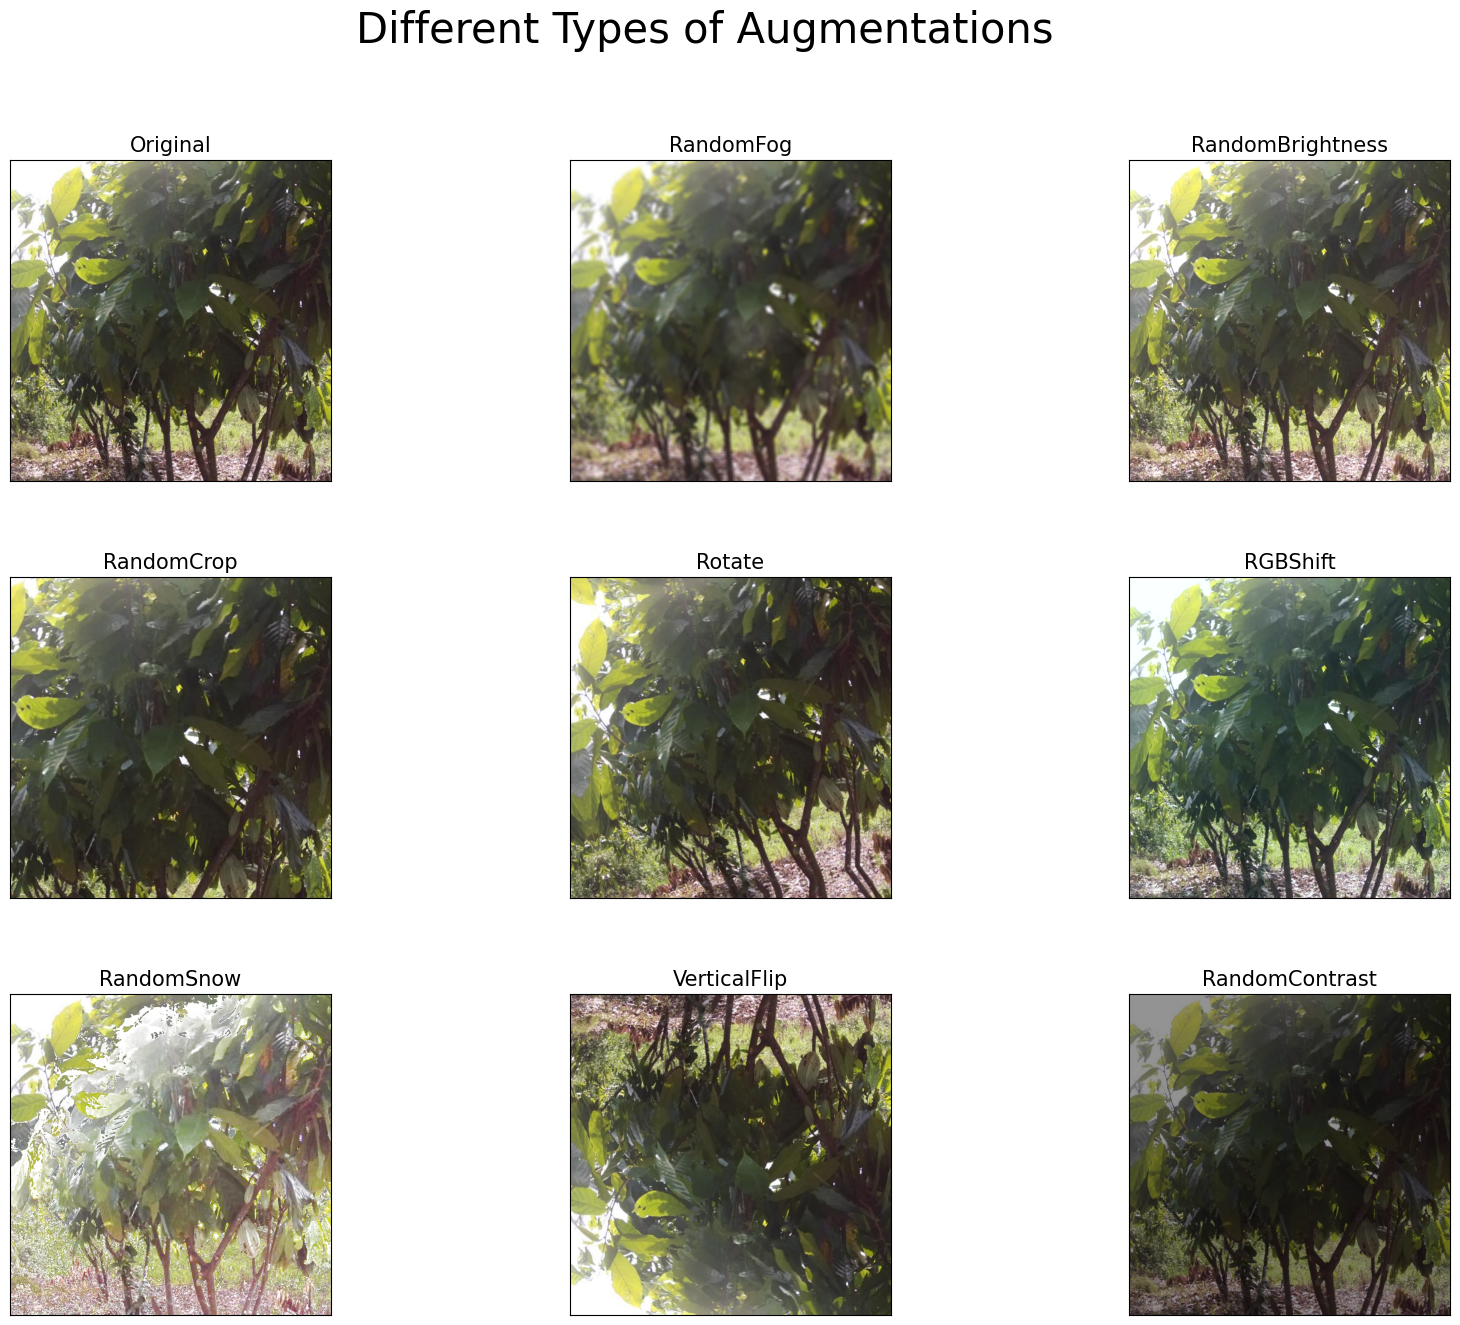

In [ ]:
visualize_transformed_images(sample_image)

In [ ]:
#mosaic AUgmentation
transform2 = A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(450, 450), height=640, width=640, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2,
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2,
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=640, width=640, p=1),
            #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            #ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='yolo',
            min_area=0,
            min_visibility=0,
            #label_fields=['labels']
        )
    )

In [ ]:
def apply_transform(image,bboxes ,transform):
  augmented = transform(image=image,bboxes=bboxes)
  return augmented['image'], augmented['bboxes']

To train a YOLO8 model with ultralytics, we need to convert the dataset into the appropriate format. For this we shall:
1. Create YOLO format annotations from the labeled data. The yolo format is:   
 `class_id x_min y_min x_center ycenter`
2. Organize the directories for the dataset. We shall use:  
  - yolo-data  
    - train
      - images
      - labels
    - val
      - images
      - labels
    - test
      - images
      - labels


3. Create a YAML configuration file with the dataset directories documented.

In [ ]:
# Create save directories
for d in ['base', 'train', 'val', 'test']:
  os.makedirs(f'yolo-data/{d}/images', exist_ok=True)
  os.makedirs(f'yolo-data/{d}/labels', exist_ok=True)

In [ ]:
# Create label mapping to class names
labels = label_data['Actual Label'].unique()
print(labels)


# Create a label map
cocoa_label_map = {val:idx[0] for  idx, val in np.ndenumerate(labels)}

cocoa_label_map

['Spoit' 'Immature' 'Mature_Unripe' 'Ripped']


{'Spoit': 0, 'Immature': 1, 'Mature_Unripe': 2, 'Ripped': 3}

In [ ]:
def generate_yolo_label(df, img_id, save_dir = 'yolo-data/base/labels/'):
  ext_boxes = extract_bounding_boxes_norm(df, img_id)
  img_width, img_height = (640,640)
  with open(save_dir+img_id[:-3]+'txt', 'w') as l_file:
    for b in ext_boxes:
      x1, y1, x2, y2, img_label =  b
      xc = x1+ (x2-x1)/2
      yc  = y1+ (y2-y1)/2
      l_file.write(f'{cocoa_label_map[img_label]} {x1:.6f} {y1:.6f} {xc:.6f} {yc:.6f}\n')


In [ ]:
# Test the function
generate_yolo_label(label_data, os.path.basename(sample_image))

# This should create a txt yolo format label file in yolo-data/base/labels

In [ ]:
# Loop through label_data and genrate labels for all unique image ids
for i in image_list:
  generate_yolo_label(label_data, os.path.basename(i))

Performing Augmentations

In [ ]:
# Path to the folder containing images
image_folder = '/content/cocoa_new/train'
output_folder = '/content/yolo-data/base/images'
label_dir = "/content/yolo-data/base/labels"
#os.makedirs(output_folder, exist_ok=True)

# Define allowed image extensions
allowed_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

# Get list of image filenames with allowed extensions
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and os.path.splitext(f)[1].lower() in allowed_extensions]


In [ ]:
# Apply transformations
for idx, image_file in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)
    print(image_path)
    image = cv2.imread(image_path)
    img_width = image.shape[1]
    img_height = image.shape[0]
    bboxes = generate_yolo_label_4_Aug(label_data, os.path.basename(image_file), img_width,img_height)
    def convert_and_clamp_bbox(bbox):
      """Convert bounding box coordinates to float and clamp them to the range (0, 1]."""
      return [max(1e-5, min(1.0, float(coord))) for coord in bbox[:4]] + [bbox[4]]


    bbox_list = [convert_and_clamp_bbox(bbox) for bbox in bboxes]
    if image is None:
        print(f"Failed to load image {image_file}")
        continue

    if idx < 100:
        transform = random.choice(albumentation_list)
        transformed_image, transformed_bboxes = apply_transform(image, bbox_list, transform)

    else:
        transformed_image, transformed_bboxes = apply_transform(image,bbox_list,transform2)

    # Generate new file names
    base_name, ext = os.path.splitext(image_file)
    new_image_name = f"{base_name}_augmented_{idx+1}{ext}"
    new_label_name = f"{base_name}_augmented_{idx+1}.txt"

    # Save the transformed image
    output_path = os.path.join(output_folder, new_image_name)
    cv2.imwrite(output_path, transformed_image)

    # Write labels for transformed bounding boxes
    with open(os.path.join(label_dir, new_label_name), 'w') as l_file:
        for bbox in transformed_bboxes:
            xc, yc, width, height, img_label = bbox
            l_file.write(f'{cocoa_label_map[img_label]} {width:.6f} {height:.6f} {xc:.6f} {yc:.6f}\n')


/content/cocoa_new/train/img_3815_JPG_jpg.rf.f306f5a8886da4e9fa6ad86c9c53682b.jpg
/content/cocoa_new/train/img_556_JPG_jpg.rf.8f0de22a769730c2d9aedb7102eba1e2.jpg
/content/cocoa_new/train/img_4098_JPG_jpg.rf.45d6d60e850dad008c916ce06b407424.jpg
/content/cocoa_new/train/img_3025_JPG_jpg.rf.ecbb102a98f68e40835c550b63619f96.jpg
/content/cocoa_new/train/img_4018_JPG_jpg.rf.3049084e257a548d77e2de0a985d377f.jpg
/content/cocoa_new/train/img_726_JPG_jpg.rf.949ea7d2873da63abd971b7cd5eccef3.jpg
/content/cocoa_new/train/img_3621_JPG_jpg.rf.7b77f5557e532784bd98d8000807ce5d.jpg
/content/cocoa_new/train/img_904_JPG_jpg.rf.29186ccec6748f8643ab718c80922cff.jpg
/content/cocoa_new/train/img_1385_JPG_jpg.rf.43f4b8978131610a688bbbdab09870a1.jpg
/content/cocoa_new/train/img_2786_JPG_jpg.rf.dd5a8bdb4a04485362571429a2b7fa52.jpg
/content/cocoa_new/train/img_1360_JPG_jpg.rf.6c239c4f8208b09bf63b65d4740ea24b.jpg
/content/cocoa_new/train/img_1784_JPG_jpg.rf.d2ec98e1ea495ae2c07ee8e77a17dbac.jpg
/content/cocoa_new/

#### Create train test and validation datasets.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Get all labels
base_labels = glob.glob('yolo-data/base/labels/*.txt')
print(f'Found {len(base_labels)} files.')

Found 5178 files.


Validation images

In [ ]:
data_dir = 'cocoa_new/valid/'
data_dir = pathlib.Path(data_dir).with_suffix('')

image_count = len(list(data_dir.glob('*.jpg')))
print(f'Found {image_count} images')

Found 630 images


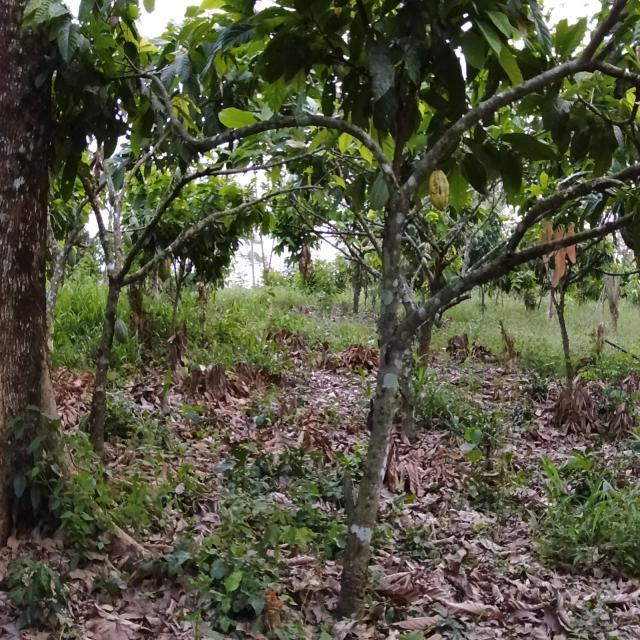

In [ ]:
val_image_list = list(data_dir.glob('*.jpg'))
Image.open(str(val_image_list[0]))

In [ ]:
def generate_yolo_label_val(df, img_id, save_dir = 'yolo-data/val/labels/'):
  ext_boxes = extract_bounding_boxes_norm(df, img_id)
  img_width, img_height = (640,640)
  with open(save_dir+img_id[:-3]+'txt', 'w') as l_file:
    for b in ext_boxes:
      x1, y1, x2, y2, img_label =  b
      xc = x1+ (x2-x1)/2
      yc  = y1+ (y2-y1)/2
      l_file.write(f'{cocoa_label_map[img_label]} {x1:.6f} {y1:.6f} {xc:.6f} {yc:.6f}\n')


In [ ]:
for i in val_image_list:
    generate_yolo_label_val(val_data, os.path.basename(i))

In [ ]:
# Get all labels
base_labels = glob.glob('yolo-data/base/labels/*.txt')
print(f'Found {len(base_labels)} files.')


train, val = train_test_split(base_labels, test_size=0.3, random_state=3873)
#val, test = train_test_split(temp, test_size=0.5, random_state=928)


print(f'Train has {len(train)} samples')
print(f'Val has {len(val)} samples')
#print(f'Test has {len(test)} samples')

Found 5178 files.
Train has 3624 samples
Val has 1554 samples


In [ ]:

def move_images(source_folder, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # List all files in the source folder
    for filename in os.listdir(source_folder):
        # Check if the file is an image by its extension
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.svg')):
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(destination_folder, filename)
            # Move the file
            shutil.move(source_path, destination_path)
            print(f'Moved: {filename}')

    print('All images have been moved.')

# Example usage:
source_folder = '/content/cocoa_new/train'
destination_folder = '/content/yolo-data/base/images'
move_images(source_folder, destination_folder)

Moved: img_3815_JPG_jpg.rf.f306f5a8886da4e9fa6ad86c9c53682b.jpg
Moved: img_556_JPG_jpg.rf.8f0de22a769730c2d9aedb7102eba1e2.jpg
Moved: img_4098_JPG_jpg.rf.45d6d60e850dad008c916ce06b407424.jpg
Moved: img_3025_JPG_jpg.rf.ecbb102a98f68e40835c550b63619f96.jpg
Moved: img_4018_JPG_jpg.rf.3049084e257a548d77e2de0a985d377f.jpg
Moved: img_726_JPG_jpg.rf.949ea7d2873da63abd971b7cd5eccef3.jpg
Moved: img_3621_JPG_jpg.rf.7b77f5557e532784bd98d8000807ce5d.jpg
Moved: img_904_JPG_jpg.rf.29186ccec6748f8643ab718c80922cff.jpg
Moved: img_1385_JPG_jpg.rf.43f4b8978131610a688bbbdab09870a1.jpg
Moved: img_2786_JPG_jpg.rf.dd5a8bdb4a04485362571429a2b7fa52.jpg
Moved: img_1360_JPG_jpg.rf.6c239c4f8208b09bf63b65d4740ea24b.jpg
Moved: img_1784_JPG_jpg.rf.d2ec98e1ea495ae2c07ee8e77a17dbac.jpg
Moved: img_3162_JPG_jpg.rf.1eda264a8f57188e2390cf847d35d583.jpg
Moved: img_4072_JPG_jpg.rf.7ded1289623ebe37ed319b5cf2e26f0c.jpg
Moved: img_1768_JPG_jpg.rf.1e92d9f24c7367d3cec211836bc432e6.jpg
Moved: img_364_JPG_jpg.rf.0adfcf54dd0551ba4

In [ ]:
def move_images(source_folder, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # List all files in the source folder
    for filename in os.listdir(source_folder):
        # Check if the file is an image by its extension
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.svg')):
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(destination_folder, filename)
            # Move the file
            shutil.move(source_path, destination_path)
            print(f'Moved: {filename}')

    print('All images have been moved.')

# Example usage:
source_folder = '/content/cocoa_new/valid'
destination_folder = '/content/yolo-data/val/images'
move_images(source_folder, destination_folder)

Moved: img_2481_JPG_jpg.rf.1745f6478d7f30e24f9ca7bb702476e1.jpg
Moved: img_315_JPG_jpg.rf.04fda93e1f1edd31c174f003aad05b03.jpg
Moved: img_1145_JPG_jpg.rf.1dd660148f9cd54201712d0ada275992.jpg
Moved: img_657_JPG_jpg.rf.9812d59ce5a487b6582eab53e7497643.jpg
Moved: img_4090_JPG_jpg.rf.4c249a25676dfab819d02107ea33354f.jpg
Moved: img_3654_JPG_jpg.rf.61bed9649eedafb14aa5dbbe54e25bdf.jpg
Moved: img_3818_JPG_jpg.rf.0f6fed162c8800cf0f9f130547e25ee2.jpg
Moved: img_559_JPG_jpg.rf.a762adc11a7c540ab64765e7b6ea2211.jpg
Moved: img_2954_JPG_jpg.rf.d86e11a6386434ec4c5e9bdbd0c66ecf.jpg
Moved: img_3578_JPG_jpg.rf.bc1e99386d5099adc5d32ec7ea63be2b.jpg
Moved: img_1232_JPG_jpg.rf.7d1804dd86b01830c720ee51c540700f.jpg
Moved: img_3614_JPG_jpg.rf.e7413dd4f2911279e5150200b1a070cd.jpg
Moved: img_257_JPG_jpg.rf.d88a3f93d6559a6041ff1e002862f764.jpg
Moved: img_635_JPG_jpg.rf.c96475a33d6defe6167ba7691e33241e.jpg
Moved: img_2003_JPG_jpg.rf.589518522c473b55c6459ed9ee71adaa.jpg
Moved: img_204_JPG_jpg.rf.11020794a70dd952697

In [ ]:
# Copy files to respective folders
for f in train:
  i_name = os.path.basename(f)[:-3]+'jpg'
  shutil.copyfile(f, 'yolo-data/train/labels/'+os.path.basename(f))
  shutil.copyfile('/content/yolo-data/base/images/'+i_name, 'yolo-data/train/images/'+i_name)

#for f in test:
  #i_name = os.path.basename(f)[:-3]+'jpg'
  #shutil.copyfile(f, 'yolo-data/test/labels/'+os.path.basename(f))
  #shutil.copyfile('cocoa_new/train/'+i_name, 'yolo-data/test/images/'+i_name)

for f in val:
  i_name = os.path.basename(f)[:-3]+'jpg'
  shutil.copyfile(f, 'yolo-data/val/labels/'+os.path.basename(f))
  shutil.copyfile('/content/yolo-data/base/images/'+i_name, 'yolo-data/val/images/'+i_name)

### Create a YAML data configuration file for training

In [ ]:
yaml_dict = {
    'path': '/content/yolo-data',
    'train': 'train/images',
    'val': 'val/images',
    'names': {idx[0]: val for  idx, val in np.ndenumerate(labels)}

}

with open('data_config.yaml', 'w+') as yml_file:
    yaml.dump(yaml_dict, yml_file)

## Model training


You can consider logging your runs to a service like [WandB](https://wandb.ai/site)

In [ ]:
# set some options
# Visit https://docs.ultralytics.com/modes/train/#train-settings to seee complete settings

batch = -1
patience = 5
epochs = 50
optimizer = 'AdamW'
lr= 0.000450
data_config = '/content/data_config.yaml'
project = 'cocoa-training' # folder where train runs will be stored
name = 'exp_v1.1'  # custom name for specific run folder, may need to make this dynamic

In [ ]:
# Load model
# Visit https://docs.ultralytics.com/ for more details about the YOLO model.
model_version = 'yolov8s.pt' # can pick from yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
model = YOLO(model_version)

100%|██████████| 21.5M/21.5M [00:00<00:00, 258MB/s]


**Check model benchmarks [here](https://docs.ultralytics.com/tasks/segment/#models)**

In [ ]:
# Initialize wandB (optional) but recommended
! wandb init

In [ ]:
import wandb
wandb.login()

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Train the model
results = model.train(data=data_config, epochs=epochs, imgsz=640, project=project, patience=patience, name=name,
                      batch=batch, optimizer=optimizer,lr0=lr)

Ultralytics YOLOv8.2.21 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data_config.yaml, epochs=50, time=None, patience=5, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=cocoa-training, name=exp_v1.12, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

train: Scanning /content/yolo-data/train/labels.cache... 3624 images, 485 backgrounds, 0 corrupt: 100%|██████████| 3624/3624 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/yolo-data/val/labels.cache... 2184 images, 174 backgrounds, 0 corrupt: 100%|██████████| 2184/2184 [00:00<?, ?it/s]


Plotting labels to cocoa-training/exp_v1.12/labels.jpg... 
optimizer: AdamW(lr=0.00035, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00059375), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to cocoa-training/exp_v1.12
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       9.3G      1.677      2.783      2.323         59        640: 100%|██████████| 96/96 [01:32<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:32<00:00,  1.12s/it]


                   all       2184      10795     0.0133       0.18    0.00867    0.00433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.25G      1.309      2.403      2.018         38        640: 100%|██████████| 96/96 [01:27<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:32<00:00,  1.13s/it]


                   all       2184      10795      0.245      0.231       0.15     0.0872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.33G      1.258       2.33      1.968         55        640: 100%|██████████| 96/96 [01:28<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.18s/it]


                   all       2184      10795      0.301       0.32      0.229      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.41G      1.227      2.256      1.925         64        640: 100%|██████████| 96/96 [01:27<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


                   all       2184      10795      0.295      0.308      0.221      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.35G      1.208      2.244        1.9         80        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:33<00:00,  1.16s/it]


                   all       2184      10795      0.289       0.32      0.234      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.49G      1.174      2.203      1.864         48        640: 100%|██████████| 96/96 [01:27<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:32<00:00,  1.14s/it]


                   all       2184      10795      0.303      0.329      0.242      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.45G       1.17      2.186      1.851         76        640: 100%|██████████| 96/96 [01:29<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:33<00:00,  1.16s/it]


                   all       2184      10795       0.34      0.352      0.281      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.41G      1.161      2.144      1.847         48        640: 100%|██████████| 96/96 [01:29<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:32<00:00,  1.13s/it]


                   all       2184      10795      0.314      0.328       0.25       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.39G       1.13      2.119      1.807         66        640: 100%|██████████| 96/96 [01:31<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:32<00:00,  1.13s/it]


                   all       2184      10795      0.303      0.337      0.251      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.34G      1.122      2.089      1.803         98        640: 100%|██████████| 96/96 [01:32<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:30<00:00,  1.05s/it]


                   all       2184      10795      0.398      0.344      0.302      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.04G      1.116      2.059      1.792         60        640: 100%|██████████| 96/96 [01:33<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


                   all       2184      10795      0.385      0.329      0.303      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.35G      1.114      2.022      1.799         68        640: 100%|██████████| 96/96 [01:32<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:30<00:00,  1.04s/it]


                   all       2184      10795      0.414      0.362      0.326      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.49G      1.092      2.019       1.77         70        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]


                   all       2184      10795      0.398      0.363      0.317       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       9.4G      1.098      1.987      1.771         56        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:33<00:00,  1.17s/it]


                   all       2184      10795      0.426      0.353      0.329      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.39G      1.063      1.955      1.743         46        640: 100%|██████████| 96/96 [01:29<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


                   all       2184      10795      0.409      0.377      0.344      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.41G      1.065      1.939      1.743         33        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:33<00:00,  1.15s/it]


                   all       2184      10795      0.444      0.356      0.342      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.19G      1.065      1.921       1.74         42        640: 100%|██████████| 96/96 [01:29<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:33<00:00,  1.16s/it]


                   all       2184      10795      0.422      0.383      0.354      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.39G      1.046      1.885      1.714         51        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:35<00:00,  1.22s/it]


                   all       2184      10795      0.407      0.373       0.35      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.34G      1.038      1.866      1.713         74        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.18s/it]


                   all       2184      10795        0.4      0.348      0.321      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.34G       1.04       1.84      1.702         40        640: 100%|██████████| 96/96 [01:29<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.20s/it]


                   all       2184      10795      0.468       0.37      0.373      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       9.4G      1.033      1.812      1.699         41        640: 100%|██████████| 96/96 [01:28<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


                   all       2184      10795      0.461      0.382       0.37      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.33G      1.024      1.773      1.698         53        640: 100%|██████████| 96/96 [01:28<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:35<00:00,  1.24s/it]


                   all       2184      10795      0.464      0.397      0.387       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.34G      1.018      1.772      1.682         53        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:33<00:00,  1.14s/it]


                   all       2184      10795      0.501      0.392       0.41      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       9.4G      1.016      1.762      1.687         43        640: 100%|██████████| 96/96 [01:29<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.20s/it]


                   all       2184      10795      0.475      0.392      0.395      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.39G      1.006       1.72      1.668         72        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:33<00:00,  1.17s/it]


                   all       2184      10795      0.454      0.384      0.379      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.32G      1.006      1.719      1.671         46        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:32<00:00,  1.14s/it]


                   all       2184      10795      0.519      0.387      0.407      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.33G          1      1.688       1.66         78        640: 100%|██████████| 96/96 [01:31<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:32<00:00,  1.13s/it]


                   all       2184      10795      0.521      0.372      0.398      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.33G     0.9959      1.678      1.647         64        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:31<00:00,  1.08s/it]


                   all       2184      10795      0.504      0.387      0.418       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.32G     0.9866      1.639      1.644         74        640: 100%|██████████| 96/96 [01:32<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:30<00:00,  1.07s/it]


                   all       2184      10795      0.541      0.389      0.412      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.35G     0.9799      1.631      1.638         87        640: 100%|██████████| 96/96 [01:31<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:32<00:00,  1.12s/it]


                   all       2184      10795      0.482      0.399      0.407      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.32G     0.9716      1.618      1.629         77        640: 100%|██████████| 96/96 [01:31<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:30<00:00,  1.04s/it]


                   all       2184      10795       0.51        0.4      0.412      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.46G     0.9704      1.605      1.618         67        640: 100%|██████████| 96/96 [01:33<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:29<00:00,  1.03s/it]


                   all       2184      10795      0.582      0.406      0.446      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.39G     0.9637      1.582       1.62         69        640: 100%|██████████| 96/96 [01:32<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:30<00:00,  1.06s/it]


                   all       2184      10795      0.526      0.423      0.435       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.34G     0.9518      1.553      1.614         45        640: 100%|██████████| 96/96 [01:33<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]


                   all       2184      10795      0.579      0.397      0.441      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.34G     0.9605      1.556      1.614         38        640: 100%|██████████| 96/96 [01:32<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:31<00:00,  1.07s/it]


                   all       2184      10795      0.579      0.408      0.454      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.41G     0.9392      1.509      1.593         87        640: 100%|██████████| 96/96 [01:33<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:32<00:00,  1.12s/it]

                   all       2184      10795      0.602      0.394       0.45      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.43G     0.9353        1.5      1.593         58        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.18s/it]


                   all       2184      10795      0.585      0.401      0.446       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.42G     0.9407      1.508      1.594         54        640: 100%|██████████| 96/96 [01:31<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


                   all       2184      10795      0.608      0.404      0.461      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.42G     0.9343      1.476      1.583         59        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.18s/it]


                   all       2184      10795      0.608       0.41      0.468      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.34G     0.9368      1.475      1.586         77        640: 100%|██████████| 96/96 [01:30<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.18s/it]


                   all       2184      10795      0.629      0.388      0.461      0.343
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.38G     0.9376      1.478       1.59         60        640: 100%|██████████| 96/96 [01:35<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:32<00:00,  1.14s/it]


                   all       2184      10795      0.622      0.404      0.458      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.34G     0.9245      1.459      1.581         43        640: 100%|██████████| 96/96 [01:31<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


                   all       2184      10795      0.639      0.395      0.464      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.34G     0.9234      1.429      1.564         52        640: 100%|██████████| 96/96 [01:29<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:33<00:00,  1.14s/it]


                   all       2184      10795      0.624      0.395      0.458      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.41G      0.921      1.426      1.571         79        640: 100%|██████████| 96/96 [01:28<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:33<00:00,  1.17s/it]


                   all       2184      10795      0.646      0.396      0.466      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.38G     0.9105      1.397       1.56         76        640: 100%|██████████| 96/96 [01:31<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:36<00:00,  1.26s/it]


                   all       2184      10795      0.614      0.406      0.472       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.39G      0.915      1.401      1.565         89        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.20s/it]


                   all       2184      10795      0.612      0.414      0.469      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.11G     0.9101      1.389      1.562         58        640: 100%|██████████| 96/96 [01:30<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:35<00:00,  1.22s/it]

                   all       2184      10795      0.632      0.401       0.47      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.35G     0.9029      1.382      1.555         79        640: 100%|██████████| 96/96 [01:29<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:33<00:00,  1.16s/it]


                   all       2184      10795      0.634      0.405      0.468      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       9.4G     0.8924      1.367      1.543         50        640: 100%|██████████| 96/96 [01:33<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:34<00:00,  1.20s/it]


                   all       2184      10795      0.652      0.398      0.473       0.36
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 44, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

49 epochs completed in 1.714 hours.
Optimizer stripped from cocoa-training/exp_v1.12/weights/last.pt, 22.5MB
Optimizer stripped from cocoa-training/exp_v1.12/weights/best.pt, 22.5MB

Validating cocoa-training/exp_v1.12/weights/best.pt...
Ultralytics YOLOv8.2.21 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:44<00:00,  1.52s/it]


                   all       2184      10795      0.647      0.396      0.467      0.362
                 Spoit       2184       2313       0.56      0.429       0.46      0.354
              Immature       2184       3042      0.627      0.367      0.451      0.351
         Mature_Unripe       2184       5028      0.653      0.452      0.533      0.415
                Ripped       2184        412      0.747      0.337      0.423      0.329
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to cocoa-training/exp_v1.12


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Evaluate the model
metrics = model.val()

Ultralytics YOLOv8.2.20 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/yolo-data/val/labels.cache... 1085 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1085/1085 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


                   all       1085       5885       0.45      0.422      0.397      0.291
                 Spoit       1085       1199      0.462      0.479       0.44      0.325
              Immature       1085       1671      0.444      0.366      0.361      0.257
         Mature_Unripe       1085       2773      0.485      0.507      0.487      0.366
                Ripped       1085        242      0.409      0.335      0.301      0.214
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to cocoa-training/exp_v1.12


You can view the results in the saved directory as shown above.  
In this case, results have been stored to the directory `cocoa-training/exp_v1.1/`

# Make Predictions

In [ ]:
# Load test data
test_data = glob.glob('cocoa_new/test_new/*.jpg')
chunk_size = 10  # Adjust this based on your memory constraints
results = []
import torch

for i in range(0, len(test_data), chunk_size):
    batch = test_data[i:i + chunk_size]
    with torch.no_grad():  # Disable gradient calculation
        batch_results = model.predict(batch, save=False, show_labels=False, show_conf=False, conf=0.1)
    results.extend(batch_results)

#results = model.predict(test_data, save=True, show_labels=False, show_conf=False, conf=0.1)


0: 640x640 4 Spoits, 4 Immatures, 7 Mature_Unripes, 47.5ms
1: 640x640 3 Spoits, 1 Immature, 1 Mature_Unripe, 47.5ms
2: 640x640 4 Spoits, 7 Immatures, 13 Mature_Unripes, 47.5ms
3: 640x640 2 Mature_Unripes, 47.5ms
4: 640x640 3 Spoits, 8 Immatures, 16 Mature_Unripes, 1 Ripped, 47.5ms
5: 640x640 3 Immatures, 4 Mature_Unripes, 47.5ms
6: 640x640 6 Spoits, 3 Mature_Unripes, 2 Rippeds, 47.5ms
7: 640x640 5 Spoits, 2 Immatures, 1 Mature_Unripe, 47.5ms
8: 640x640 1 Immature, 12 Mature_Unripes, 47.5ms
9: 640x640 2 Mature_Unripes, 47.5ms
Speed: 11.9ms preprocess, 47.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Immature, 11 Mature_Unripes, 11.9ms
1: 640x640 2 Immatures, 11 Mature_Unripes, 11.9ms
2: 640x640 1 Spoit, 2 Immatures, 7 Mature_Unripes, 1 Ripped, 11.9ms
3: 640x640 2 Spoits, 3 Mature_Unripes, 11.9ms
4: 640x640 12 Mature_Unripes, 11.9ms
5: 640x640 2 Immatures, 11 Mature_Unripes, 11.9ms
6: 640x640 3 Immatures, 19 Mature_Unripes, 11.9ms
7: 640x640 1 Immatu

You can find results in the specified folder under the save dir.  
Let's explore what is in our predictions.

In [ ]:
print(len(results))

317


The results contain predictions for each input image.  
Lets look at one.

In [ ]:
results[7]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Spoit', 1: 'Immature', 2: 'Mature_Unripe', 3: 'Ripped'}
obb: None
orig_img: array([[[ 33,  53,  41],
        [ 30,  50,  38],
        [ 27,  46,  37],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 34,  53,  44],
        [ 31,  50,  41],
        [ 27,  46,  37],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 32,  53,  45],
        [ 29,  50,  42],
        [ 26,  47,  39],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 65,  74,  94],
        [ 68,  77,  97],
        [ 85,  94, 114],
        ...,
        [ 38,  50,  78],
        [ 33,  43,  73],
        [ 38,  48,  78]],

       [[ 75,  84, 104],
        [ 71,  80, 100],
        [ 74,  83, 103],
        ...,
        [ 34,  4

This returns a dictionary of many values.   
We are mainly interested in the boxes data.

In [ ]:
# Get boxes from predictions
results[7].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 2., 2.], device='cuda:0')
conf: tensor([0.8209, 0.6755, 0.4742], device='cuda:0')
data: tensor([[1.3846e+02, 1.6396e+02, 4.9800e+02, 5.1572e+02, 8.2087e-01, 2.0000e+00],
        [1.9140e+02, 2.9873e+00, 6.1382e+02, 2.9304e+02, 6.7548e-01, 2.0000e+00],
        [3.3645e+02, 3.4032e+01, 5.6411e+02, 2.4794e+02, 4.7422e-01, 2.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([3, 6])
xywh: tensor([[318.2316, 339.8408, 359.5455, 351.7653],
        [402.6075, 148.0119, 422.4172, 290.0493],
        [450.2794, 140.9879, 227.6636, 213.9112]], device='cuda:0')
xywhn: tensor([[0.4972, 0.5310, 0.5618, 0.5496],
        [0.6291, 0.2313, 0.6600, 0.4532],
        [0.7036, 0.2203, 0.3557, 0.3342]], device='cuda:0')
xyxy: tensor([[138.4588, 163.9581, 498.0044, 515.7234],
        [191.3989,   2.9873, 613.8160, 293.0365],
        [336.4476,  34.0323, 564.1111, 247.9435]], device='cuda:0')


This also returns a dictionary of many values. The values of interest are:  
1. **xywh** - This returns the bounding box coordinates in an array representing `[x_min, y_min, bounding_box_width , bounding_box_height]`
2. **xyxy** - This returns the bounding box coordinates in an array representing `[x_min, y_min, x_max , y_max]`
3. The values **xywhn** and **xyxyn** are the same as above only that they are normalized. In this case, the bounding box coordinates in `xyxyn` are what we need to prepare our submission file.
4. The **conf** returns the confidences of the bounding boxes.
5. The **cls** value returns the classes predicted for each bounding box


In [ ]:
# We shall extract the normalized coordinates as that is what we are interested in
# We shall also get the predicted classes. For this we shall use the label map to get the actual class later
# Finally we shall get the confidence values of the predictions.

filenames = [os.path.basename(r.path) for idx, r in enumerate(results) for b in r.boxes.xyxyn.cpu().numpy()]
pred_boxes = np.concatenate([r.boxes.xyxyn.cpu().numpy() for r in results])
pred_classes = np.concatenate([r.boxes.cls.cpu().numpy() for r in results])
pred_confidence = np.concatenate([r.boxes.conf.cpu().numpy() for r in results])
# for r in results:
#   pred_boxes = np.append(r.boxes.xyxyn.cpu().numpy())
# results[7].boxes.xyxyn.cpu().numpy()

### Creating a Submission file
The CSv must have 7 columns:  
`filename, Class, Confidence, ymin, xmin, ymax, xmax`.   

Each row represents a detected bounding box in an image.  
 - Class: The cocoa class (e.g. cocoa mature unripe, cocoa immature, cocoa ripped or cocoa spoilt.)
 - Confidence: Confidence score of the detection (between 0 and 1)
 - ymin, xmin, ymax, xmax: Normalized bounding box coordinates (between 0 and 1).

  - ymin: Top-left y-coordinate (0 at the top of the image)
  - xmin: Top-left x-coordinate (0 at the left of the image)
  - ymax: Bottom-right y-coordinate (1 at the bottom of the image)
  - xmax: Bottom-right x-coordinate (1 at the right of the image)


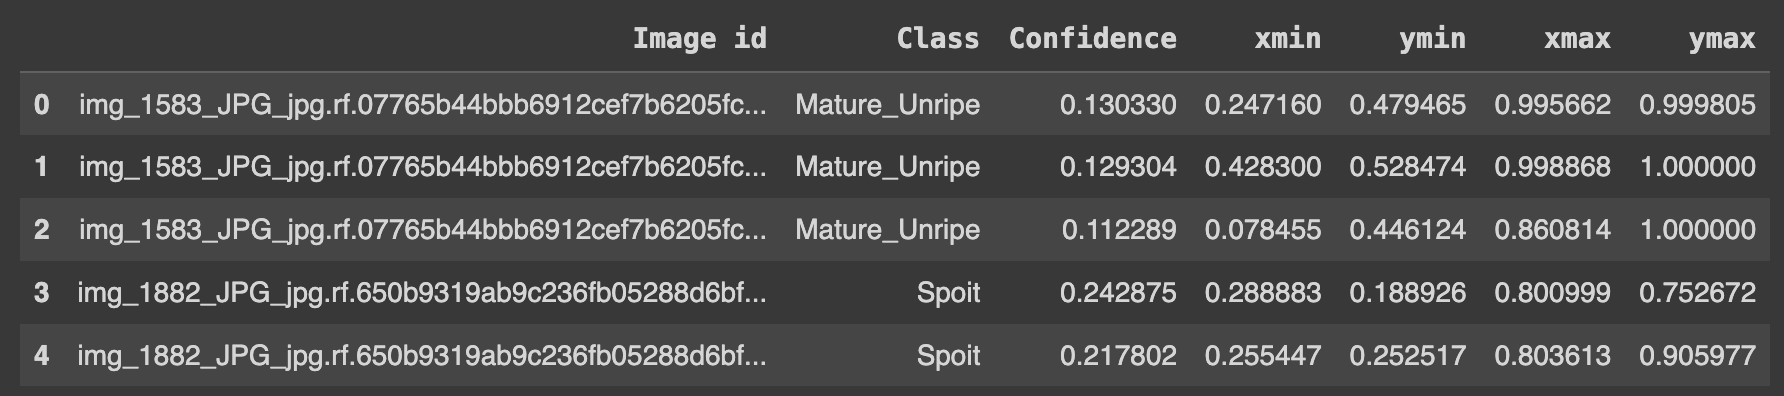

In [ ]:
# Lets reverse the labelmap
cocoa_label_map_rev = {cocoa_label_map[key]:key for key in cocoa_label_map}
cocoa_label_map_rev

{0: 'Spoit', 1: 'Immature', 2: 'Mature_Unripe', 3: 'Ripped'}

In [ ]:
# Get Actual Labels by from predicted classes
pred_labels = list(map(lambda x : cocoa_label_map_rev[x], list(pred_classes.astype(int))))

In [ ]:
submission_df = pd.DataFrame(
    {
        'Image id': filenames,
        'Class': pred_labels,
        'Confidence': pred_confidence,
        'xmin': pred_boxes[:, 0],
        'ymin': pred_boxes[:, 1],
        'xmax': pred_boxes[:, 2],
        'ymax': pred_boxes[:, 3],

    }
)

submission_df.head()

Image id          Class  \
0  img_1992_JPG_jpg.rf.2f91a7295abc9543cb3b89c499...  Mature_Unripe   
1  img_1992_JPG_jpg.rf.2f91a7295abc9543cb3b89c499...  Mature_Unripe   
2  img_1992_JPG_jpg.rf.2f91a7295abc9543cb3b89c499...  Mature_Unripe   
3  img_1992_JPG_jpg.rf.2f91a7295abc9543cb3b89c499...       Immature   
4  img_1992_JPG_jpg.rf.2f91a7295abc9543cb3b89c499...  Mature_Unripe   

   Confidence      xmin      ymin      xmax      ymax  
0    0.599967  0.215760  0.064645  0.769148  0.485791  
1    0.359625  0.385414  0.028464  1.000000  0.521543  
2    0.354020  0.225297  0.217138  0.791727  0.790119  
3    0.306400  0.229116  0.251464  0.792642  0.846806  
4    0.202169  0.627605  0.111771  0.930943  0.423991

In [ ]:
# Save to a CSV
submission_df.to_csv('Harvest Haven.csv', index=False)

Ensure that your CSV is named with your team name. For example if the team name is Expendables, the CSV must be saves as `Expendables.csv`

## Optional- Export to tflite model for mobile inference

In [ ]:
# Export model
# form = "tflite"
# model.export(format=form)